# InDebted DA Takehome - Keith Santos
I'll be doing an EDA to answer these 5 questions and hopefully gain more insights 

1. How should we handle the missing values for the columns age and customer_country?
2. What time of the day should we send our messages in each country?
3. What should be the preferred channel to use when communicating with customers?
4. What are the main metrics, dimensions and filters to be included in the dashboard?
5. What is the communications performance over time? What could be causing this behaviour?


In [96]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu

pd.set_option('display.max_rows', None)

In [227]:
df_csv = pd.read_csv('communications.csv')#, on_bad_lines='skip')
print(df_csv["customer_id"].nunique())
print(df_csv.shape)
df_csv.head()

9751
(145941, 15)


,message_id,customer_id,sent_at,clicked,converted,client_id,gender,customer_country,age,created_at,client_name,product_type,client_country,channel,message_number
0,28d82c62db5989d9441351f58738c6a8,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-01-04 10:03:16.376000+00:00,0,0,cfcd208495d565ef66e7dff9f98764da,F,NaN,51.0,2021-01-03 15:58:50.376000+00:00,SwanPay,BNPL,UK,SMS,1.0
1,0f98a1bbf7f2b66f420816a65c8d9b77,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-01-12 08:34:09.376000+00:00,0,0,cfcd208495d565ef66e7dff9f98764da,F,NaN,51.0,2021-01-03 15:58:50.376000+00:00,SwanPay,BNPL,UK,SMS,2.0
2,97f9ed967d2334ce0b4ebfcfc9b5c25c,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-01-19 08:58:11.376000+00:00,0,0,cfcd208495d565ef66e7dff9f98764da,F,NaN,51.0,2021-01-03 15:58:50.376000+00:00,SwanPay,BNPL,UK,Email,3.0
3,3d0615ca493d69e16265ab688495c134,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-01-28 10:43:04.376000+00:00,0,0,cfcd208495d565ef66e7dff9f98764da,F,NaN,51.0,2021-01-03 15:58:50.376000+00:00,SwanPay,BNPL,UK,Email,4.0
4,3eb3a03a007bd1adf7482e6d95f7b942,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-02-04 11:28:56.376000+00:00,0,0,cfcd208495d565ef66e7dff9f98764da,F,NaN,51.0,2021-01-03 15:58:50.376000+00:00,SwanPay,BNPL,UK,Email,5.0


In [5]:
df_csv.dtypes

message_id           object
customer_id          object
sent_at              object
clicked               int64
converted             int64
client_id            object
gender               object
customer_country     object
age                 float64
created_at           object
client_name          object
product_type         object
client_country       object
channel              object
message_number      float64
dtype: object

## 1. How should we handle the missing values for the columns age and customer_country?
- Tried to see if splitting the UTC from the datetime and doing the value counts would yield certain values that correspond to customer_country but didn't expect so much variation for UTC 

In [6]:
df_csv.isna().sum()

message_id              0
customer_id             0
sent_at                 0
clicked                 0
converted               0
client_id               0
gender              31676
customer_country    30146
age                 22020
created_at              0
client_name             0
product_type            0
client_country          0
channel                 0
message_number          0
dtype: int64

In [7]:
df_csv['customer_country'].value_counts()

UK    49146
CA    33911
NZ    32738
Name: customer_country, dtype: int64

In [8]:
#df_csv["age"].value_counts().sort_index()

UTC doesn't seem to be customer country specific and some NaNs share the same UTC with only 1 other customer country but don't think it's indicative + too much work to manually check if there are 2 matches

In [178]:
df_UTCtest = pd.DataFrame(columns=['customer_country','UTC'])
df_UTCtest['customer_country'] = df_csv['customer_country'].copy()
df_UTCtest['UTC'] = df_csv['sent_at'].str.split('.').str[1].copy()

In [179]:
df_UTCtest.fillna('None', inplace=True)
df_UTCtest.head()

,customer_country,UTC
0,None,376000+00:00
1,None,376000+00:00
2,None,376000+00:00
3,None,376000+00:00
4,None,376000+00:00


In [180]:
df_UTCtest['customer_country'].value_counts()

UK      49146
CA      33911
NZ      32738
None    30146
Name: customer_country, dtype: int64

Comparing the means and medians of the messages each person receives comparing ones that have missing info values and the ones that don't

In [207]:
df_missing_customercountries = df_csv.loc[df_csv['customer_country'].isna()].copy()
df_missing_customercountries.shape

(30146, 15)

In [189]:
df_complete_customercountries = df_csv.loc[df_csv['customer_country'].notnull()].copy()
df_complete_customercountries.shape

(115795, 15)

In [190]:
column_holder = 'customer_id'

print(df_missing_customercountries[column_holder].value_counts().mean())
print(df_csv[column_holder].value_counts().mean())
print(df_complete_customercountries[column_holder].value_counts().mean())

print(df_missing_customercountries[column_holder].value_counts().median())
print(df_csv[column_holder].value_counts().median())
print(df_complete_customercountries[column_holder].value_counts().median())

15.891407485503427
14.966772638703723
14.743442831678125
14.0
13.0
12.0


In [192]:
df_missing_valcounts = pd.DataFrame(columns=['messages_per_person'])
df_complete_valcounts = pd.DataFrame(columns=['messages_per_person'])

df_missing_valcounts["messages_per_person"] = df_missing_customercountries[column_holder].value_counts().values
df_complete_valcounts["messages_per_person"] = df_complete_customercountries[column_holder].value_counts().values

print(df_missing_valcounts.shape)
print(df_complete_valcounts.shape)

(1897, 1)
(7854, 1)


Mann Whitney U test shows a statistically significant p when comparing the samples of numbers of messages per person that have missing customer country vs that don't have missing customer country

In [202]:
_, pnorm = mannwhitneyu(df_missing_valcounts["messages_per_person"].sample(n=1500), df_complete_valcounts["messages_per_person"].sample(n=1500), method="asymptotic")
print(pnorm)

0.0019775527339291853


<AxesSubplot: >

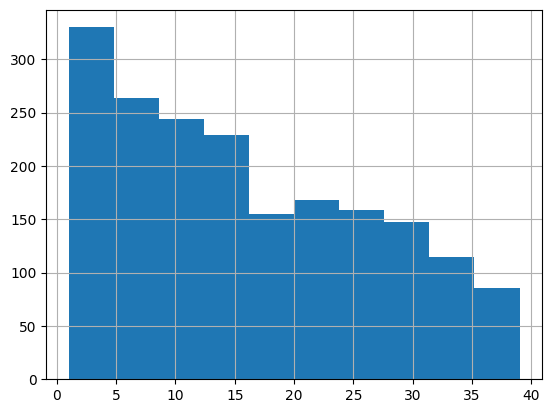

In [201]:
df_missing_valcounts["messages_per_person"].hist()

<AxesSubplot: >

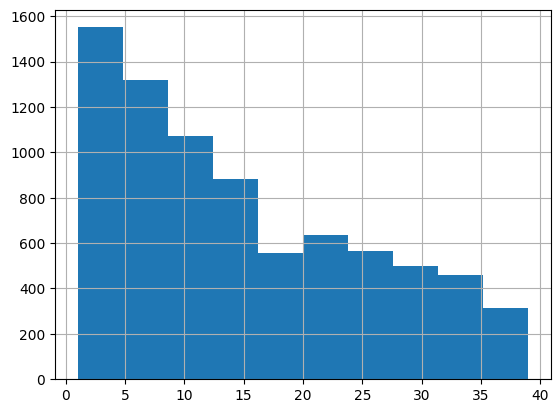

In [195]:
df_complete_valcounts["messages_per_person"].hist()

## 2. What time of the day should we send our messages in each country?

In [242]:
df_csv['sent_at'] = pd.to_datetime(df_csv['sent_at'], errors='coerce')
df_csv.dtypes

message_id                       object
customer_id                      object
sent_at             datetime64[ns, UTC]
clicked                           int64
converted                         int64
client_id                        object
gender                           object
customer_country                 object
age                             float64
created_at                       object
client_name                      object
product_type                     object
client_country                   object
channel                          object
message_number                  float64
dtype: object

In [243]:
# df containing rows which the message was clicked OR replied to
df_clicked_converted = df_csv.loc[(df_csv['clicked'] == 1) | (df_csv['converted'] == 1 )].copy()
df_clicked_converted.reset_index(inplace=True, drop=True)

print(df_clicked_converted["customer_id"].nunique())
print(df_clicked_converted.shape)
df_clicked_converted.head()

6086
(9374, 15)


,message_id,customer_id,sent_at,clicked,converted,client_id,gender,customer_country,age,created_at,client_name,product_type,client_country,channel,message_number
0,b362af6f8c490377462744f70a524665,26c5f8755c296b92685959c57114ba75,2021-04-28 11:50:25.127000+00:00,1,0,cfcd208495d565ef66e7dff9f98764da,F,NZ,28.0,2021-01-03 16:55:05.127000+00:00,SwanPay,BNPL,UK,Email,17.0
1,97863b5325e02095b46eede5430df32f,26c5f8755c296b92685959c57114ba75,2021-06-17 10:25:45.127000+00:00,1,0,cfcd208495d565ef66e7dff9f98764da,F,NZ,28.0,2021-01-03 16:55:05.127000+00:00,SwanPay,BNPL,UK,Email,24.0
2,3aa8304b816ebf485ee3068e47e62ff3,26c5f8755c296b92685959c57114ba75,2021-09-03 09:52:09.127000+00:00,1,0,cfcd208495d565ef66e7dff9f98764da,F,NZ,28.0,2021-01-03 16:55:05.127000+00:00,SwanPay,BNPL,UK,Email,35.0
3,40684a56c92c67e11c2800e2e423e9c3,06e72df8cce37d99724e98a89ff031e0,2021-01-13 15:48:51.167000+00:00,1,0,cfcd208495d565ef66e7dff9f98764da,F,UK,24.0,2021-01-03 18:20:36.167000+00:00,SwanPay,BNPL,UK,Email,2.0
4,e4f91bd680bb8c2ff2489a016527465c,06e72df8cce37d99724e98a89ff031e0,2021-01-19 09:04:59.167000+00:00,1,1,cfcd208495d565ef66e7dff9f98764da,F,UK,24.0,2021-01-03 18:20:36.167000+00:00,SwanPay,BNPL,UK,Email,3.0


In [244]:
# df containing rows which the message was replied to
df_converted = df_csv.loc[(df_csv['converted'] == 1 )].copy()
df_converted.reset_index(inplace=True, drop=True)

print(df_converted["customer_id"].nunique())
print(df_converted.shape)
df_converted.head()

3142
(3142, 15)


,message_id,customer_id,sent_at,clicked,converted,client_id,gender,customer_country,age,created_at,client_name,product_type,client_country,channel,message_number
0,e4f91bd680bb8c2ff2489a016527465c,06e72df8cce37d99724e98a89ff031e0,2021-01-19 09:04:59.167000+00:00,1,1,cfcd208495d565ef66e7dff9f98764da,F,UK,24.0,2021-01-03 18:20:36.167000+00:00,SwanPay,BNPL,UK,Email,3.0
1,177d6b78abf38591b5352177e2e4cbbb,6c106790e67f6988b943e6971cbe1d04,2021-07-08 15:45:25.423000+00:00,1,1,cfcd208495d565ef66e7dff9f98764da,F,NaN,29.0,2021-01-01 08:52:53.423000+00:00,SwanPay,BNPL,UK,SMS,27.0
2,798cfc63f3a821ff919bb74cc42240ac,15c286543a1dbf6ab2c855747f751cb7,2021-09-15 12:17:59.064000+00:00,1,1,cfcd208495d565ef66e7dff9f98764da,NaN,NaN,27.0,2021-01-01 01:49:55.064000+00:00,SwanPay,BNPL,UK,Email,36.0
3,82fd83a85b4154c2de4c01459d8b8123,ab93a807d958811fdcf7e1f8fc39bd2a,2021-02-26 10:06:20.605000+00:00,1,1,cfcd208495d565ef66e7dff9f98764da,F,UK,NaN,2021-01-03 21:58:36.605000+00:00,SwanPay,BNPL,UK,Email,8.0
4,9238b01b87d0121a97d36dda6b7507a0,abd9d49a461b10861017f60f1b4770d9,2021-05-31 17:23:34.681000+00:00,1,1,cfcd208495d565ef66e7dff9f98764da,F,UK,19.0,2021-01-03 00:00:36.681000+00:00,SwanPay,BNPL,UK,Email,22.0


Interesting to see that **3142 / 9751 (32.22%) customers eventually respond** but **only 9374 / 145941 (6.42%) of messages are either clicked or responded to**. It seems that **out of the users that do engage with the comapany (click OR respond), only 3142 / 6086 (51.53%) lead to a conversation**, which I assume is the "success" factor since there have been rows with the same user clicking and not responding but that leads to more messages sent to them until they either do respond or a message threshold (35+) is reached.

In [252]:
df_converted.isna().sum()
df_converted.dtypes

message_id                       object
customer_id                      object
sent_at             datetime64[ns, UTC]
clicked                           int64
converted                         int64
client_id                        object
gender                           object
customer_country                 object
age                             float64
created_at                       object
client_name                      object
product_type                     object
client_country                   object
channel                          object
message_number                  float64
day_of_week                       int64
day_of_week_sent                  int64
hour_sent                         int64
dtype: object

In [249]:
# Monday = 0 Sunday = 6
df_converted["day_of_week_sent"] = df_converted["sent_at"].dt.weekday.copy()
df_converted["day_of_week_sent"].value_counts()

3    748
1    716
2    679
4    676
0    323
Name: day_of_week_sent, dtype: int64

<AxesSubplot: xlabel='day_of_week_sent', ylabel='converted'>

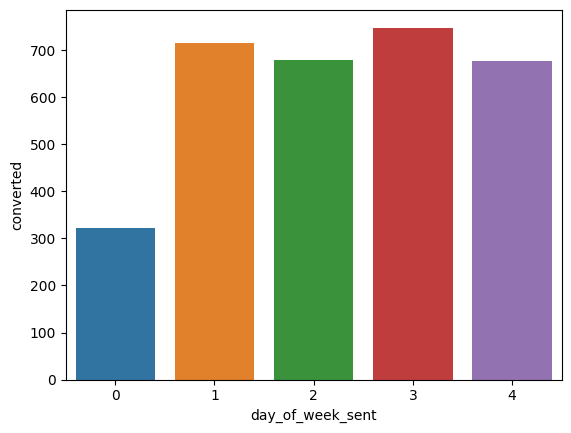

In [283]:
df_dayofweek_aggregate = df_converted.groupby(by=["day_of_week_sent"]).sum(numeric_only=True)
df_dayofweek_aggregate.reset_index(inplace=True, drop=False)
sns.barplot(data=df_dayofweek_aggregate, x='day_of_week_sent', y='converted')

In [251]:
df_converted["hour_sent"] = df_converted["sent_at"].dt.hour.copy()
df_converted["hour_sent"].value_counts()

10    679
9     642
11    589
8     193
14    154
16    152
15    142
12    140
13    124
18    113
17    110
19    104
Name: hour_sent, dtype: int64

<AxesSubplot: xlabel='hour_sent', ylabel='converted'>

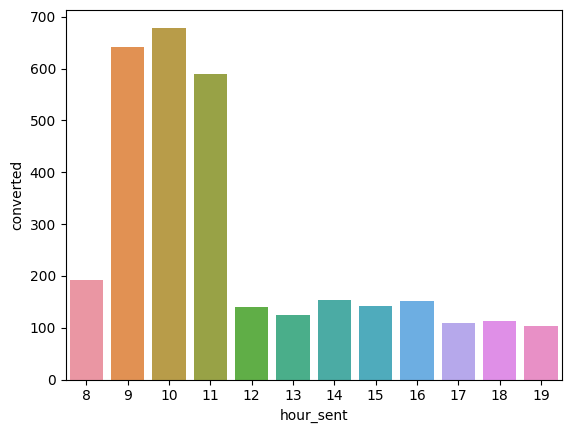

In [284]:
df_hour_aggregate = df_converted.groupby(by=["hour_sent"]).sum(numeric_only=True)
df_hour_aggregate.reset_index(inplace=True, drop=False)
sns.barplot(data=df_hour_aggregate, x='hour_sent', y='converted')

### Looking into separating the replied messages via hour and country

In [297]:
def conversions_location_aggregate(source_df, country, aggregate_column):
    df_country_filtered = source_df.loc[(source_df['customer_country'] == country )].copy()
    df_country_filtered_hour_aggregate = df_country_filtered.groupby(by=[aggregate_column]).sum(numeric_only=True)
    df_country_filtered_hour_aggregate.reset_index(inplace=True, drop=False)
    plot = sns.barplot(data=df_country_filtered_hour_aggregate, x=aggregate_column, y='converted')
    plot.set_title(f'{aggregate_column} response counts for people in {country}', fontsize=14, fontweight="bold", y=1.01)

In [279]:
df_converted["customer_country"].value_counts()

CA    1336
UK     990
NZ     321
Name: customer_country, dtype: int64

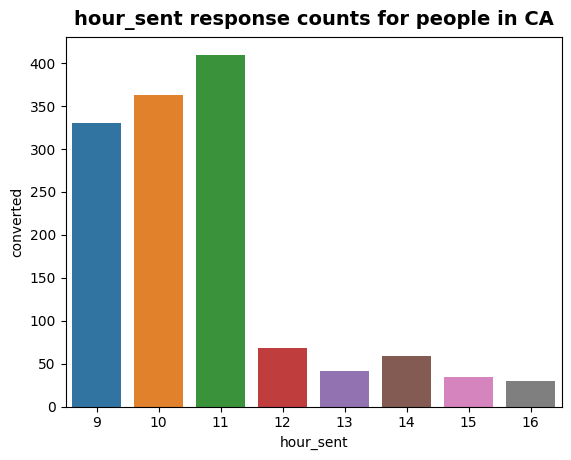

In [298]:
conversions_location_aggregate(df_converted, "CA", "hour_sent")

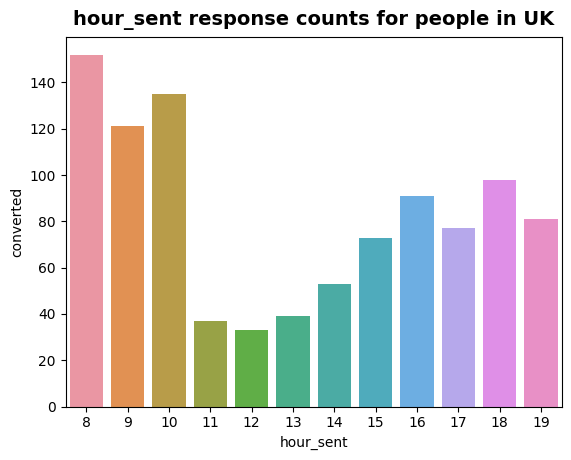

In [299]:
conversions_location_aggregate(df_converted, "UK", "hour_sent")

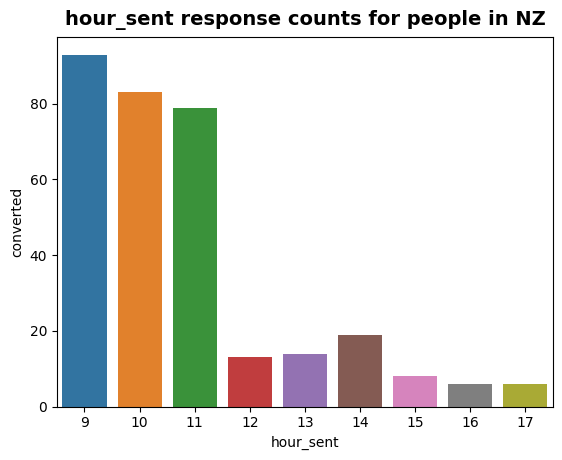

In [300]:
conversions_location_aggregate(df_converted, "NZ", "hour_sent")

### Does age have anything to do with when they reply or not?

<AxesSubplot: xlabel='converted', ylabel='age'>

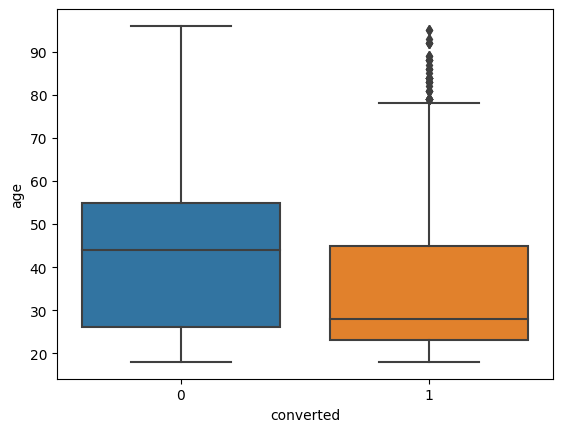

In [228]:
sns.boxplot(x="converted", y="age", data=df_csv)

## 3. What should be the preferred channel to use when communicating with customers?

In [285]:
df_channel_aggregate = df_converted.groupby(by=["channel"]).sum(numeric_only=True)
df_channel_aggregate.reset_index(inplace=True, drop=False)
df_channel_aggregate
#sns.barplot(data=df_dayofweek_aggregate, x='day_of_week_sent', y='converted')

,channel,clicked,converted,age,message_number,day_of_week,day_of_week_sent,hour_sent
0,Email,1916,1916,58391.0,19686.0,4231,4231,22255
1,SMS,1226,1226,37695.0,12877.0,2791,2791,14226


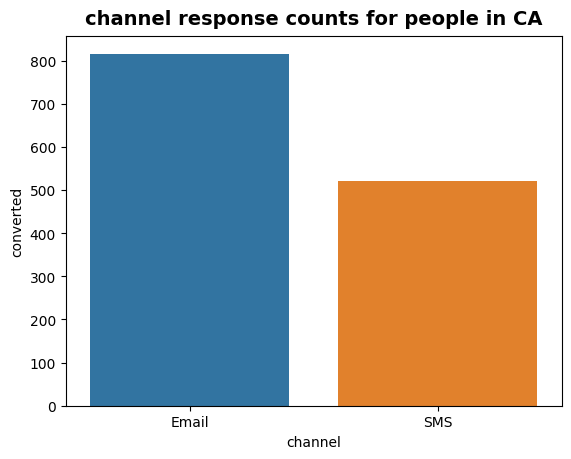

In [301]:
conversions_location_aggregate(df_converted, "CA", "channel")

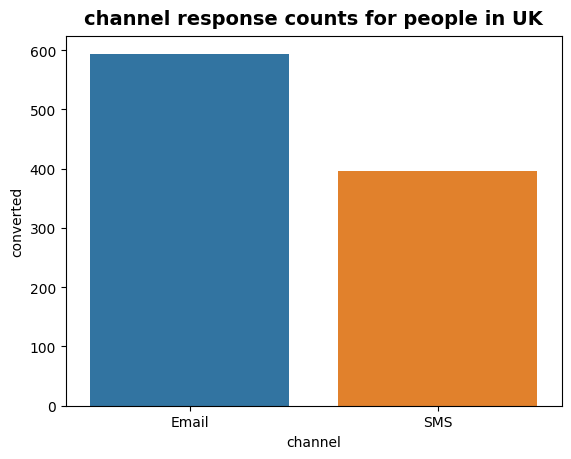

In [302]:
conversions_location_aggregate(df_converted, "UK", "channel")

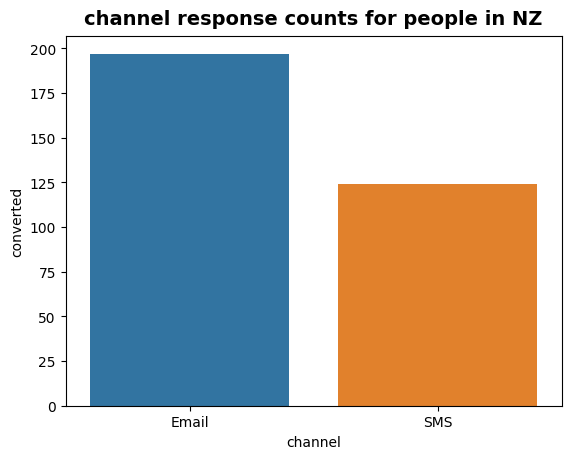

In [303]:
conversions_location_aggregate(df_converted, "NZ", "channel")

## 5. What is the communications performance over time? What could be causing this behaviour?

In [304]:
print(df_csv["sent_at"].min())
print(df_csv["sent_at"].max())

2021-01-04 10:03:16.376000+00:00
2021-10-01 19:58:46.086000+00:00


In [307]:
df_timeslice = df_csv.filter(['customer_id','sent_at','clicked', 'converted', 'customer_country', 'message_number'], axis=1)
df_timeslice.head()

,customer_id,sent_at,clicked,converted,customer_country,message_number
0,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-01-04 10:03:16.376000+00:00,0,0,NaN,1.0
1,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-01-12 08:34:09.376000+00:00,0,0,NaN,2.0
2,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-01-19 08:58:11.376000+00:00,0,0,NaN,3.0
3,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-01-28 10:43:04.376000+00:00,0,0,NaN,4.0
4,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-02-04 11:28:56.376000+00:00,0,0,NaN,5.0


Will look into how many days on average is spent messaging a person then will try to see if the average per yearly quarter shortens or remainds consistent. Might separate this by ones that respond and ones that don't

In [314]:
df_timeslice['diff'] = df_timeslice.groupby('customer_id')['sent_at'].diff() // np.timedelta64(1, 'D')
df_timeslice['diff'].fillna(0, inplace=True)
df_timeslice.head()

,customer_id,sent_at,clicked,converted,customer_country,message_number,diff
0,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-01-04 10:03:16.376000+00:00,0,0,NaN,1.0,0.0
1,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-01-12 08:34:09.376000+00:00,0,0,NaN,2.0,7.0
2,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-01-19 08:58:11.376000+00:00,0,0,NaN,3.0,7.0
3,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-01-28 10:43:04.376000+00:00,0,0,NaN,4.0,9.0
4,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-02-04 11:28:56.376000+00:00,0,0,NaN,5.0,7.0


## 4. What are the main metrics, dimensions and filters to be included in the dashboard?